# Progress report 1

*Asura Enkhbayar, 09.03.2020*

This report covers intermediate results for:

- **Citation parsing** on the unstructured references in order to retrieve identifiers and other metadata in the input dataset
- **Crossref queries** using the unstructured references from the original dataset
- Additional **NCBI identifiers** queried with the DOIs retrieved from Crossref
- **Altmetric counts** for articles with DOIs retrieved from Crossref

In [ ]:
import numpy as np
import os
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from military_grants import project_dir, data_dir
from military_grants import CR_THRESH

In [ ]:
# Articles after processing with anystyle
articles = pd.read_csv(data_dir / "interim/structured.csv", index_col="article_id")

# External data from CR/Altmetric
crossref = pd.read_csv(data_dir / "interim/_crossref.csv", index_col="article_id", low_memory=False)
altmetric = pd.read_csv(data_dir / "interim/_altmetric.csv", index_col="article_id", low_memory=False)
ncbi = pd.read_csv(data_dir / "interim/_ncbi.csv", index_col="article_id")

## Citation Parsing

Our input dataset contains unstructured references in the form of strings that were typed in by the original authors.

Using [anystyle](https://github.com/inukshuk/anystyle) we can attempt to retrieve DOIs, PMIDs, PMCIDs, and other structured metadata from these strings.

In [3]:
x = articles[['DOI', 'PMID', 'PMCID']].count().to_frame('Articles with')
x[f'% (n={len(articles)})'] = 100 * x['Articles with'] / len(articles)
x.round(1)

,Articles with,% (n=18708)
DOI,546,2.9
PMID,163,0.9
PMCID,96,0.5


**As we can see the number of identifiers extractred from the input dataset is not really useful.**

## Crossref results

Crossref provides an API endpoint for textual searches using references. We are using that endpoint and retrieving the best candidate for each query. The results contain a score which refers to the quality of the match.

We are currently using 80 as the threshold for that score. We are still hoping to get in touch with one developer at Crossref who has been working on citation matching.

In [4]:
CR_THRESH

80

The following plot shows the distribution of matching scores including the score of 80 which I have currently chosen based on some prelim experimentation and manual inspection of random articles.

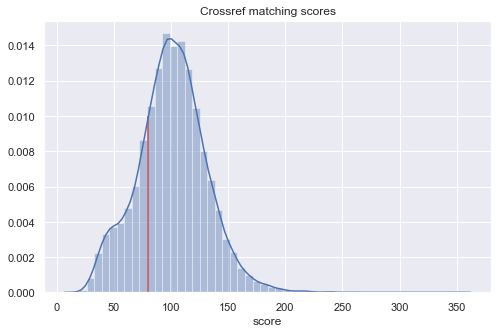

In [18]:
sns.distplot(crossref.score)
plt.title("Crossref matching scores")
plt.vlines(cr_thresh, 0, 0.010, "r");

In [27]:
# Join article metadata and crossref results
df = articles[['type', 'DOI', 'PMCID', 'PMID']]
df = df.join(crossref, rsuffix="_cr")

Different thresholds and the resulting number of matches:

In [28]:
scores = df.score
ts = [60, 70, 80, 90, 100]

for t in ts:
    print(f"{t}: {scores.where(scores>=t).count()} articles ({100*scores.where(scores>=t).count()//len(articles)}%)")

60: 16906 articles (90%)
70: 15934 articles (85%)
80: 14406 articles (77%)
90: 12248 articles (65%)
100: 9594 articles (51%)


For this particular notebook, I am using the **threshold of 80** to determine which articles were found in Crossref.

In [29]:
# Filter out DOIs that had a score lower than 80
df.loc[df.score < cr_thresh, 'DOI_cr'] = None
articles_with_doi = df[df.DOI_cr.notna()].index

In [30]:
x = df[['DOI_cr']].count().to_frame('Articles with')
x[f'% (n={len(articles)})'] = 100 * x['Articles with'] / len(articles)
x.round(1)

,Articles with,% (n=18708)
DOI_cr,14406,77.0


**Using a minimum score of 80, we have found 14,406 DOIs in Crossref which corresponds to 77% of the original dataset**

## Additional identifiers from NCBI

Using the APIs provided by the NCBI we can now also attempt to convert DOIs to pmid/pmcid.

In [9]:
x = ncbi[['pmid', 'pmcid']].count().to_frame('Articles with')
x[f'% (n={len(articles)})'] = 100 * x['Articles with'] / len(articles)
x.round(1)

,Articles with,% (n=18708)
pmid,5112,27.3
pmcid,5123,27.4


The results for the NCBI API were not very great once I started to manually check several examples. Furthermore, we can only retrieve pmid/pmcids for articles that already have a DOI. These identifiers are therefore not really useful for the processing pipeline, but might be interesting to report nevertheless.

## Altmetric results

We can use these DOIs to retrieve altmetrics for these articles.

In [56]:
df2 = altmetric.reindex(articles_with_doi)
df2 = df2[['altmetric_id', 'cited_by_tweeters_count', 'cited_by_fbwalls_count',
     'cited_by_feeds_count', 'cited_by_msm_count', 'cited_by_wikipedia_count', 'cited_by_rdts_count']]
df2.columns = ["altmetric_id", 'tweets', 'fb_mentions', 'blogposts', 'news', 'wikipedia', 'reddit']

### Coverage

First percentage only considers articles that had a DOI (n=14,406)

Second percentage uses the input dataset as the denominator (n=18,708)

In [57]:
x = df2.count().to_frame('Articles with')
x[f'% (n={len(df2)})'] = 100 * x['Articles with'] / len(df2)
x.round(1).sort_values("Articles with", ascending=False)

,Articles with,% (n=14406)
altmetric_id,7117,49.4
tweets,2126,14.8
wikipedia,1171,8.1
fb_mentions,609,4.2
news,541,3.8
blogposts,520,3.6
reddit,37,0.3


- **7,117 articles (50% of the articles with DOI) returned with an altmetric_id**
- **Twitter: 15%, Facebook: 4%**
- 8.1% for Wikipedia (is that considered high?)

### Details for altmetric counts 

In [58]:
df2.describe().round(1)

,altmetric_id,tweets,fb_mentions,blogposts,news,wikipedia,reddit
count,7117.0,2126.0,609.0,520.0,541.0,1171.0,37.0
mean,18811159.0,7.9,4.6,1.6,5.0,1.4,1.3
std,18072344.1,24.5,62.3,1.5,9.0,1.7,0.7
min,101417.0,1.0,1.0,1.0,1.0,1.0,1.0
25%,3311373.0,1.0,1.0,1.0,1.0,1.0,1.0
50%,8181500.0,2.0,1.0,1.0,2.0,1.0,1.0
75%,41322904.0,6.0,2.0,2.0,6.0,1.0,1.0
max,76583497.0,460.0,1538.0,18.0,114.0,36.0,4.0
